In [60]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd


In [61]:
# ---------------------------
# 1. Utility Functions
# ---------------------------
def set_seed(seed=42):
    """Set random seed for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

# Paths
base_path = "/kaggle/input/impulse/Impulse/EEG_Data"
train_path = os.path.join(base_path, "train_data")
val_path = os.path.join(base_path, "validation_data")
test_path = os.path.join(base_path, "test_data")

class_mapping = {
    "Complex_Partial_Seizures": 1,
    "Electrographic_Seizures": 2,
    "Video_detected_Seizures_with_no_visual_change_over_EEG": 3,
    "Normal": 0
}

def load_labeled_data(data_path, class_mapping):
    data, labels = [], []
    for class_name, label in class_mapping.items():
        class_folder = os.path.join(data_path, class_name)
        if os.path.exists(class_folder):
            for file in os.listdir(class_folder):
                if file.endswith(".npy"):
                    sample = np.load(os.path.join(class_folder, file))
                    data.append(sample)
                    labels.append(label)
    return np.array(data), np.array(labels)

def load_unlabeled_data(data_path):
    data, filenames = [], []
    for file in os.listdir(data_path):
        if file.endswith(".npy"):
            sample = np.load(os.path.join(data_path, file))
            data.append(sample)
            filenames.append(file)
    return np.array(data), filenames

In [62]:
# Data Loading
train_data, train_labels = load_labeled_data(train_path, class_mapping)
val_data, val_labels = load_labeled_data(val_path, class_mapping)
test_data, test_filenames = load_unlabeled_data(test_path)

In [63]:
def normalize_data(data):
    mean = data.mean(axis=(0, 2), keepdims=True)
    std = data.std(axis=(0, 2), keepdims=True) + 1e-8
    return ((data - mean) / std).astype(np.float32)

train_data = normalize_data(train_data)
val_data = normalize_data(val_data)
test_data = normalize_data(test_data)

In [64]:
# ---------------------------
# 2. Dataset Definition
# ---------------------------
class EEGDataset1D(Dataset):
    def __init__(self, data, labels=None, augment=False):
        self.data = torch.tensor(data, dtype=torch.float32)
        print(f"Permuted data shape: {self.data.shape}")  # Debug: Confirm shape
        self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None
        self.augment = augment # Augmentation flag

    def __len__(self):
        return len(self.data)  # Number of samples

    def __getitem__(self, idx):
        # Retrieve sample and (optionally) add noise
        sample = self.data[idx]
        if self.augment:
            sample = self.add_noise(sample.numpy())
        if self.labels is not None:
            return sample, self.labels[idx]  # Return sample with label
        return sample  # Return only sample for test data

    def add_noise(self, sample, noise_level=0.05):
        # Add Gaussian noise for augmentation
        noise = np.random.randn(*sample.shape) * noise_level
        return torch.tensor(sample + noise, dtype=torch.float32)





In [65]:
train_dataset = EEGDataset1D(train_data, train_labels, augment=True)
val_dataset = EEGDataset1D(val_data, val_labels)
test_dataset = EEGDataset1D(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


Permuted data shape: torch.Size([5608, 19, 500])
Permuted data shape: torch.Size([1403, 19, 500])
Permuted data shape: torch.Size([779, 19, 500])


In [66]:
def initialize_weights(module):
    if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

In [67]:

class Simple1DCNN(nn.Module):
    def __init__(self, input_channels, input_length, num_classes):
        super(Simple1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.batch_norm = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()

        dummy_input = torch.zeros(1, input_channels, input_length)
        self.flattened_size = self._get_flattened_size(dummy_input)

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)

        self.apply(initialize_weights)

    def _get_flattened_size(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.batch_norm(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [68]:
input_channels = train_data.shape[1]  # Features dimension (19)
input_length = train_data.shape[2]    # Sequence length (500)
num_classes = len(class_mapping)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Simple1DCNN(input_channels, input_length, num_classes).to(device)


In [69]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)



In [70]:
for batch in train_loader:
    data, labels = batch
    print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")
    break


Data shape: torch.Size([32, 19, 500]), Labels shape: torch.Size([32])


In [71]:
pip install torchsummary


Note: you may need to restart the kernel to use updated packages.


In [72]:
from torchsummary import summary

# Display a summary of the model
summary(model, input_size=(input_channels, input_length))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 500]           1,856
              ReLU-2              [-1, 32, 500]               0
         MaxPool1d-3              [-1, 32, 250]               0
            Conv1d-4              [-1, 64, 250]           6,208
              ReLU-5              [-1, 64, 250]               0
         MaxPool1d-6              [-1, 64, 125]               0
       BatchNorm1d-7              [-1, 64, 125]             128
            Linear-8                  [-1, 128]       1,024,128
              ReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 64]           8,256
             ReLU-12                   [-1, 64]               0
          Dropout-13                   [-1, 64]               0
           Linear-14                   

In [73]:
pip install torchviz


Note: you may need to restart the kernel to use updated packages.


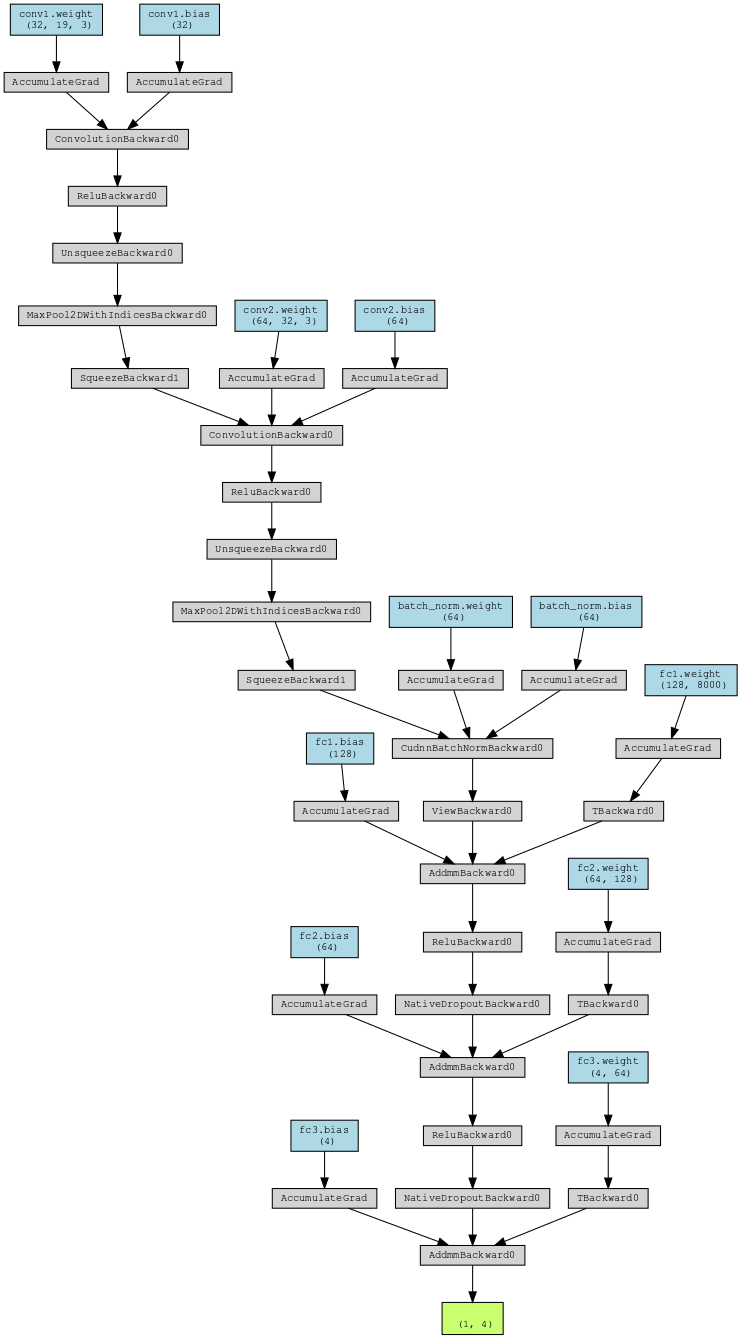

In [74]:
from torchviz import make_dot
from IPython.display import Image

# Create dummy input to pass through the model
dummy_input = torch.randn(1, input_channels, input_length).to(device)

# Generate the computational graph
graph = make_dot(model(dummy_input), params=dict(model.named_parameters()))

# Save and display the graph inline
graph.render("model_architecture", format="png", cleanup=True)
Image("model_architecture.png")


In [75]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=7):
    best_val_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = train_correct / len(train_loader.dataset)

        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model_weights.pth")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load("best_model_weights.pth"))
    return model

In [76]:
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30)


Epoch 1/30, Train Loss: 392.8482, Train Acc: 0.5314, Val Loss: 23.1557, Val Acc: 0.8076
Epoch 2/30, Train Loss: 212.9989, Train Acc: 0.6765, Val Loss: 21.3815, Val Acc: 0.8318
Epoch 3/30, Train Loss: 196.9700, Train Acc: 0.7352, Val Loss: 19.9280, Val Acc: 0.8382
Epoch 4/30, Train Loss: 122.3880, Train Acc: 0.7550, Val Loss: 20.7323, Val Acc: 0.8175
Epoch 5/30, Train Loss: 88.7350, Train Acc: 0.7926, Val Loss: 17.2645, Val Acc: 0.8517
Epoch 6/30, Train Loss: 78.2720, Train Acc: 0.8099, Val Loss: 16.5343, Val Acc: 0.8532
Epoch 7/30, Train Loss: 68.4311, Train Acc: 0.8222, Val Loss: 15.7613, Val Acc: 0.8624
Epoch 8/30, Train Loss: 62.1394, Train Acc: 0.8338, Val Loss: 19.2245, Val Acc: 0.8567
Epoch 9/30, Train Loss: 61.8806, Train Acc: 0.8311, Val Loss: 19.7790, Val Acc: 0.8803
Epoch 10/30, Train Loss: 58.2012, Train Acc: 0.8399, Val Loss: 14.5341, Val Acc: 0.8710
Epoch 11/30, Train Loss: 55.4371, Train Acc: 0.8504, Val Loss: 14.9093, Val Acc: 0.8781
Epoch 12/30, Train Loss: 56.0067, Tra

<ipython-input-75-b673d6e798c5>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_weights.pth"))


Validation Classification Report:
                          precision    recall  f1-score   support

                  Normal       0.87      0.98      0.92       696
Complex Partial Seizures       0.98      0.82      0.89       549
 Electrographic Seizures       0.96      0.96      0.96       137
 Video-detected Seizures       1.00      1.00      1.00        21

                accuracy                           0.92      1403
               macro avg       0.95      0.94      0.94      1403
            weighted avg       0.92      0.92      0.92      1403

Balanced Accuracy Score: 0.9411
ROC AUC Score (OvR): 0.9890


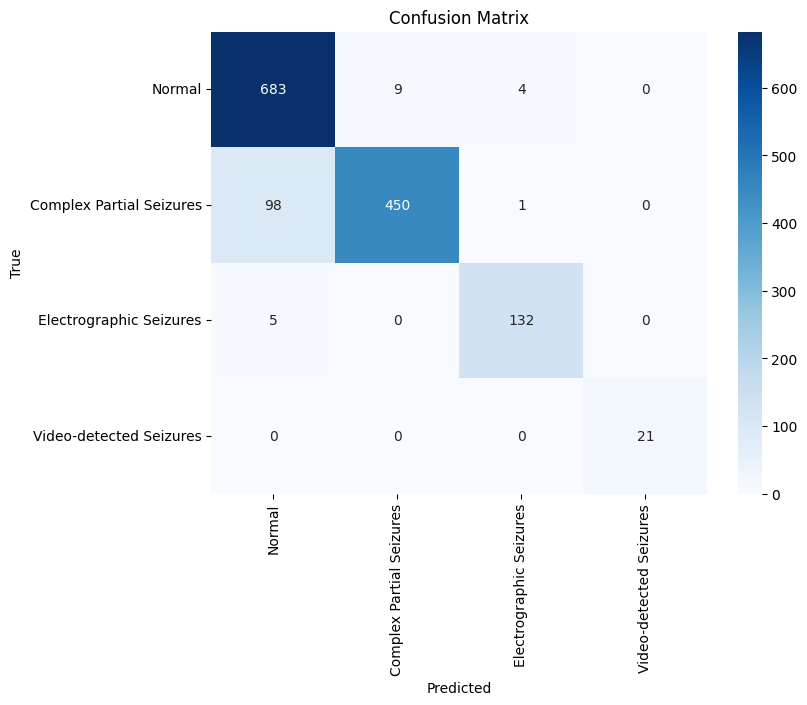

In [77]:
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_auc_score
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 6. Evaluation
# ---------------------------
def evaluate_model(model, val_loader, class_names):
    model.eval()
    val_preds, val_labels = [], []
    val_probs = []

    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = outputs.argmax(1).cpu().numpy()

            val_preds.extend(preds)
            val_probs.extend(probs)
            val_labels.extend(labels.cpu().numpy())

    # Classification Report
    print("Validation Classification Report:")
    print(classification_report(val_labels, val_preds, target_names=class_names))

    # Balanced Accuracy Score
    balanced_acc = balanced_accuracy_score(val_labels, val_preds)
    print(f"Balanced Accuracy Score: {balanced_acc:.4f}")

    # ROC AUC Score (One-vs-Rest)
    try:
        roc_auc = roc_auc_score(val_labels, val_probs, multi_class='ovr')
        print(f"ROC AUC Score (OvR): {roc_auc:.4f}")
    except ValueError:
        print("ROC AUC Score could not be computed (ensure probabilities are provided and labels are multi-class).")

    # Confusion Matrix
    cm = confusion_matrix(val_labels, val_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ["Normal", "Complex Partial Seizures", "Electrographic Seizures", "Video-detected Seizures"]
evaluate_model(trained_model, val_loader, class_names)


In [ ]:
# ---------------------------
# 7. Save Test Predictions
# ---------------------------
def generate_test_predictions(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            outputs = model(data)
            preds = outputs.argmax(1).cpu().numpy()
            predictions.extend(preds)
    return predictions

test_predictions = generate_test_predictions(trained_model, test_loader)

def save_sorted_predictions(filenames, predictions, output_file="test_predictions_cnn1d_best1.csv"):
    results = pd.DataFrame({"Filename": filenames, "Predicted Label": predictions})
    results["Numeric Order"] = results["Filename"].str.extract(r'(\d+)').astype(int)
    results = results.sort_values(by="Numeric Order").drop(columns=["Numeric Order"])
    results.to_csv(output_file, index=False)
    print(f"Test predictions saved to {output_file}")

save_sorted_predictions(test_filenames, test_predictions)